# Visual Deep Learning: Plant Health Model
### Gabriel Beutl & Alexander Schwab

#### This notebook describes the creation of a model to evaluate the health of plants. The model was trained with leaves from an apple tree. With this, an application should be able to identify if a tree is unhealthy, by providing a image form a leave of the tree. 

#### The idea to create this model is based on a project that was started last semester. The project GreenThumb is a plant health tracking app, that allows the user to keep track of the health of a plant. With the addition of a trained ai model, the application could be improved a lot in its functionality.

#### All the steps for the creation of this model are described point by point in this notebook.

### Steps to create this Machine Learning Model:

01. Setup
02. Load image data and apply data augmentation
03. Define model
04. Display model structure
05. Training model
06. Write history and plot graphs
07. Evaluate Model
08. Predict with model and display ROC
09. Save trained model
10. Load trained model
11. Test trained model

### Experiments:
The notebook tries different experiments for the creation of the best model. As such, steps 3 - 8 are repeated three times with different models.

### 1. Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import metrics
from sklearn import metrics as skmetrics

from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#Environment Variables
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
LEARNING_RATE = 0.001
MODEL_NAME = 'plant_health_model.h5'

#Folder for the data
train_data_dir = './plant_images/train'
valid_data_dir = './plant_images/valid'
test_data_dir = './plant_images/test'

#Different Metrics that get printed in the history
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.AUC(name='auc'),
      metrics.MeanAbsoluteError(name='mae'),
      metrics.MeanSquaredError(name='mse')
]

### 2. Load Image Data and apply data augmentation and preprocessing

#### The structure of the folder is the following:

-root
--plant_images
---train
----Apple_healthy
----Apple_unhealthy
---valid
----Apple_healthy
----Apple_unhealthy
---test
----Apple_healthy
----Apple_unhealthy

```
plant_images
└───train
│   └───Apple_healthy
│   │        image1.png
│   │        ...
│   └───Apple_unhealthy
│            image1.png
│            ...
└───valid
│   └───Apple_healthy
│   │        image1.png
│   │        ...
│   └───Apple_unhealthy
│            image1.png
│            ...
└───test
│   └───Apple_healthy
│   │        image1.png
│   │        ...
│   └───Apple_unhealthy
│            image1.png
│            ...
```

The train folder includes around 1400 images for the training.
The valid folder includes around 700 images to validate the trained model.
The test folder includes again around 120 images to test the model.

#### Augmentation:
For the augmentation a ImageDataGenerator is used. With this the images for the training and validation are rescaled, sheared, rotated, flipped and zoomed.
The test images are only rescaled.

In [3]:
#Create augmented training data
train_datagen = ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   validation_split=0.2,
                                   cval=0)

#Create augmented training data
train_dataset = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='training')

#Create augmented validation data
validation_dataset = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='validation')

test_datagen = ImageDataGenerator(rescale=(1. / 255))

#Create test data
test_dataset = test_datagen.flow_from_directory(test_data_dir,
                                                      target_size=IMG_SIZE,
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode='categorical')

Found 1458 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Found 714 images belonging to 2 classes.


In [4]:
# Checks if classes where found and displays them
num_classes = train_dataset.num_classes
class_names = list(train_dataset.class_indices.keys())
print(class_names)

['Apple__healthy', 'Apple__unhealthy']


### Display augmented image data

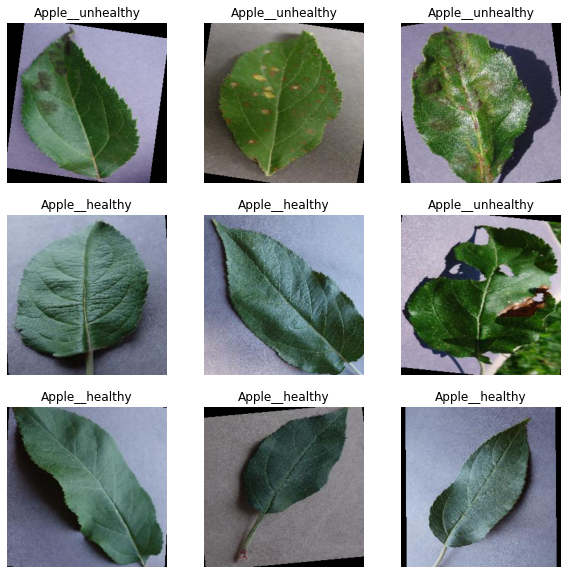

In [5]:
# display the random validation data for testing
x,y = validation_dataset.next()
labels = list(np.argmax(l) for l in y)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(x[i])
  plt.title(class_names[labels[i]])
  plt.axis("off")

## Here the experiments start with different models

### 3. Create and compile model 1

This model uses two hidden convolution layers and one dense layer to analyse the images. In between the hidden layers, max-pooling manipulates the values, to create a better learning base. Based on literature the best hidden layer activation is the relu function and for the dense activation softmax. For the loss function, the categorical_crossentropy or the binary-crossentropy (since there are only two classes) was possible for image recognition. For this example, categoriacal crossentropy worked better.

In [6]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [7]:
opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=METRICS)

### 4. Display model structure 1

In [8]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 128)     3456      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     147456    
_________________________________________________________________
flatten (Flatten)            (None, 2097152)           0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4194306   
Total params: 4,345,218
Trainable params: 4,345,218
Non-trainable params: 0
_________________________________________________________________


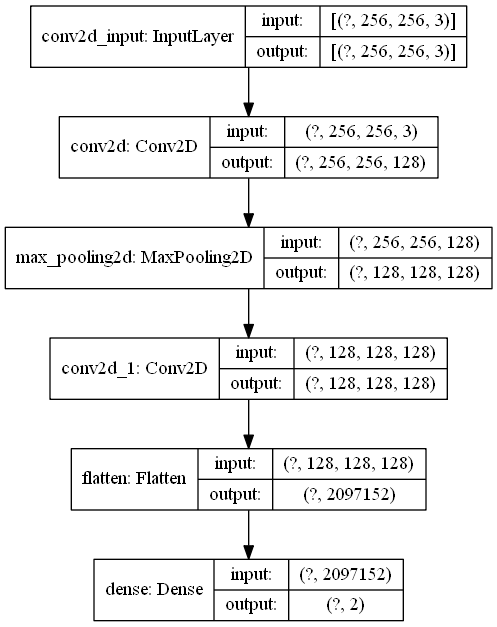

In [9]:
tf.keras.utils.plot_model(model1, show_shapes=True)

### 5. Training model 1

In [10]:
def train_model(model, model_name):
    #filepath = './models/20210610_plant_' + model_name + '_{epoch:02d}-{val_accuracy:.4f}.hdf5'
    #checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
    #                                                save_best_only=True, mode='max')
    #callbacks_list = [checkpoint]

    history = model.fit(train_dataset,
                        epochs=EPOCHS,
                        validation_data=validation_dataset)
                        #,callbacks=callbacks_list)
    return history

history1 = train_model(model1, "Model_1")

Epoch 1/50
46/46 [==============================] - 16s 356ms/step - loss: 3.1057 - tp: 956.0000 - fp: 502.0000 - tn: 956.0000 - fn: 502.0000 - accuracy: 0.6557 - precision: 0.6557 - auc: 0.6797 - mae: 0.4453 - mse: 0.2502 - val_loss: 0.4508 - val_tp: 104.0000 - val_fp: 22.0000 - val_tn: 104.0000 - val_fn: 22.0000 - val_accuracy: 0.8254 - val_precision: 0.8254 - val_auc: 0.9048 - val_mae: 0.3332 - val_mse: 0.1428
Epoch 2/50
46/46 [==============================] - 16s 338ms/step - loss: 0.3775 - tp: 1210.0000 - fp: 248.0000 - tn: 1210.0000 - fn: 248.0000 - accuracy: 0.8299 - precision: 0.8299 - auc: 0.9110 - mae: 0.2464 - mse: 0.1199 - val_loss: 0.2627 - val_tp: 113.0000 - val_fp: 13.0000 - val_tn: 113.0000 - val_fn: 13.0000 - val_accuracy: 0.8968 - val_precision: 0.8968 - val_auc: 0.9607 - val_mae: 0.1745 - val_mse: 0.0766
Epoch 3/50
46/46 [==============================] - 16s 337ms/step - loss: 0.3092 - tp: 1278.0000 - fp: 180.0000 - tn: 1278.0000 - fn: 180.0000 - accuracy: 0.8765 -

Epoch 21/50
46/46 [==============================] - 16s 338ms/step - loss: 0.2525 - tp: 1313.0000 - fp: 145.0000 - tn: 1313.0000 - fn: 145.0000 - accuracy: 0.9005 - precision: 0.9005 - auc: 0.9607 - mae: 0.1498 - mse: 0.0753 - val_loss: 0.2327 - val_tp: 113.0000 - val_fp: 13.0000 - val_tn: 113.0000 - val_fn: 13.0000 - val_accuracy: 0.8968 - val_precision: 0.8968 - val_auc: 0.9689 - val_mae: 0.1322 - val_mse: 0.0732
Epoch 22/50
46/46 [==============================] - 16s 339ms/step - loss: 0.2509 - tp: 1317.0000 - fp: 141.0000 - tn: 1317.0000 - fn: 141.0000 - accuracy: 0.9033 - precision: 0.9033 - auc: 0.9617 - mae: 0.1382 - mse: 0.0717 - val_loss: 0.2653 - val_tp: 114.0000 - val_fp: 12.0000 - val_tn: 114.0000 - val_fn: 12.0000 - val_accuracy: 0.9048 - val_precision: 0.9048 - val_auc: 0.9598 - val_mae: 0.1175 - val_mse: 0.0672
Epoch 23/50
46/46 [==============================] - 16s 342ms/step - loss: 0.2537 - tp: 1314.0000 - fp: 144.0000 - tn: 1314.0000 - fn: 144.0000 - accuracy: 0.9

### 6. Write history and plot graphs 1

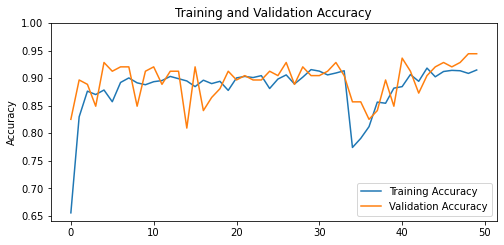

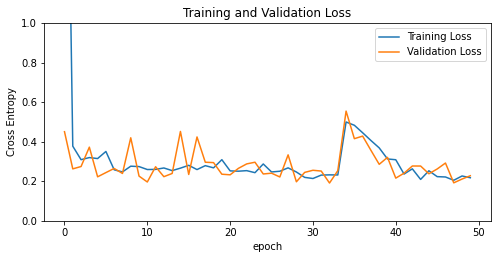

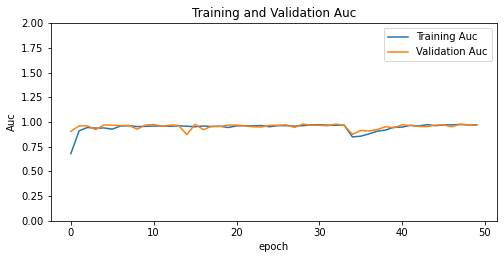

In [11]:
def print_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    auc = history.history['auc']
    val_auc = history.history['val_auc']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(auc, label='Training Auc')
    plt.plot(val_auc, label='Validation Auc')
    plt.legend(loc='upper right')
    plt.ylabel('Auc')
    plt.ylim([0,2.0])
    plt.title('Training and Validation Auc')
    plt.xlabel('epoch')
    plt.show()

print_history(history1)

### 7. Evaluate the model 1

In [12]:
def print_model_evaluation(model):
    result = model.evaluate(test_dataset)
    metrics = ["loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "auc", "mae", "mse"]
    for i in range(len(result)):
        print("{} : {}".format(metrics[i],round(result[i], 3)))

print_model_evaluation(model1);

714/714 [==============================] - 3s 5ms/step - loss: 0.3188 - tp: 624.0000 - fp: 90.0000 - tn: 624.0000 - fn: 90.0000 - accuracy: 0.8739 - precision: 0.8739 - auc: 0.9494 - mae: 0.1503 - mse: 0.0966
loss : 0.319
tp : 624.0
fp : 90.0
tn : 624.0
fn : 90.0
accuracy : 0.874
precision : 0.874
auc : 0.949
mae : 0.15
mse : 0.097


### 8. Predict with model 1

Label Predictions:
 [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0]
Real Labels:
 [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0]

Confusion Matrix:
[[19  0]
 [ 1 12]]

Accuracy: 0.97



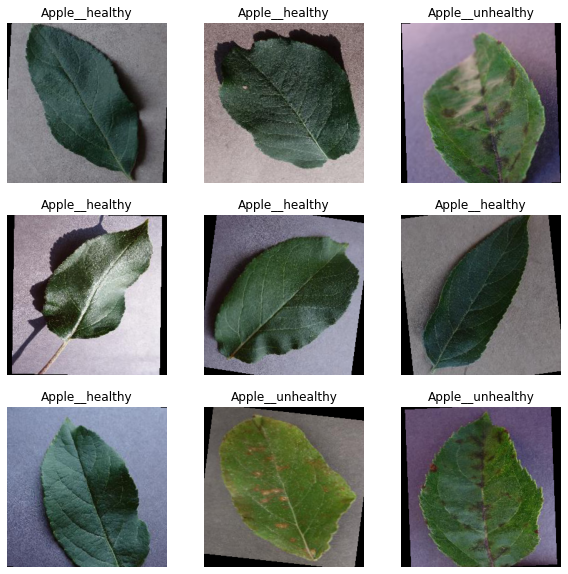

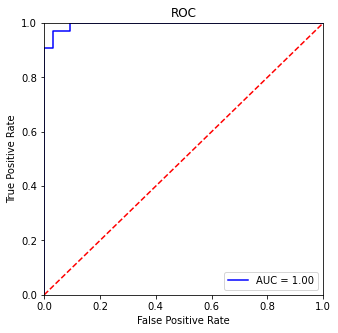

In [33]:
def predict_and_print_roc(model):
    #Retrieve one batch of images from the test set
    train_dataset.reset()
    image_batch, label_batch = train_dataset.next()

    # Predict the images from the batch
    predictions = model.predict(image_batch)

    # Visualise the actual value and the prediction in numerical form
    probs = list(np.argmax(x) for x in predictions)
    labels = list(np.argmax(x) for x in label_batch)
    print('Label Predictions:\n', probs)
    print('Real Labels:\n', labels)

    confusion = confusion_matrix(labels, probs)
    print('\nConfusion Matrix:')
    print(confusion)

    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(labels, probs)))

    #Print the first 9 Images from the batch and the estimated prediction.
    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i])
      plt.title(class_names[probs[i]])
      plt.axis("off")

    #Calculate the roc curve
    fpr, tpr, _ = skmetrics.roc_curve(label_batch.ravel(), predictions.ravel())
    roc_auc = skmetrics.auc(fpr, tpr)

    #Display ROC curve and the AUC
    plt.figure(figsize=(5, 5))
    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

predict_and_print_roc(model1);

### 3. Create and compile model 2

This model uses compared to the previouse model three convolution layers and two dense layers. The value of the neurons are decreased at each layer.

In [14]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu', use_bias=False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [15]:
opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model2.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=METRICS)

### 4. Display model structure 2

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 128)     3456      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      36864     
_________________________________________________________________
flatten_1 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4194304   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 4,234,642
Trainable params: 4,234,642
Non-trainable params: 0
____________________________________________

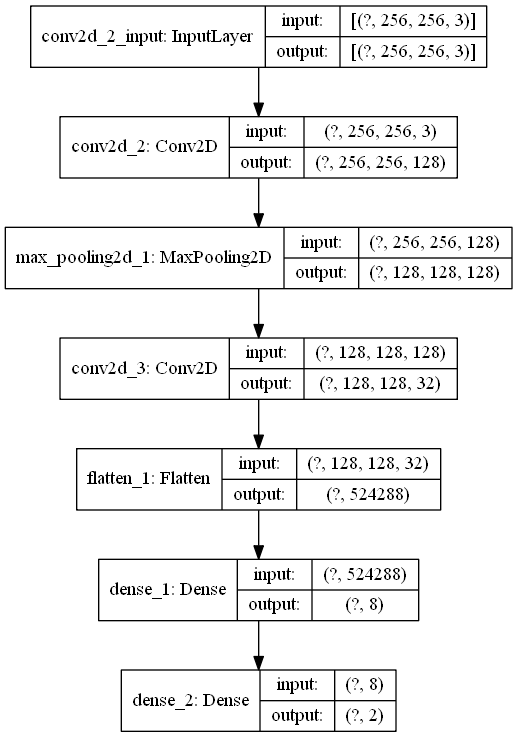

In [16]:
model2.summary()
tf.keras.utils.plot_model(model2, show_shapes=True)

### 5. Training model 2

In [17]:
history2 = train_model(model2, "Model_2")

Epoch 1/50
46/46 [==============================] - 16s 357ms/step - loss: 0.8398 - tp: 1539.0000 - fp: 632.0000 - tn: 1540.0000 - fn: 633.0000 - accuracy: 0.7086 - precision: 0.7089 - auc: 0.7869 - mae: 0.3603 - mse: 0.1921 - val_loss: 0.5052 - val_tp: 103.0000 - val_fp: 23.0000 - val_tn: 103.0000 - val_fn: 23.0000 - val_accuracy: 0.8175 - val_precision: 0.8175 - val_auc: 0.8818 - val_mae: 0.3769 - val_mse: 0.1639
Epoch 2/50
46/46 [==============================] - 16s 337ms/step - loss: 0.4783 - tp: 1178.0000 - fp: 280.0000 - tn: 1178.0000 - fn: 280.0000 - accuracy: 0.8080 - precision: 0.8080 - auc: 0.8622 - mae: 0.3090 - mse: 0.1499 - val_loss: 0.3890 - val_tp: 106.0000 - val_fp: 20.0000 - val_tn: 106.0000 - val_fn: 20.0000 - val_accuracy: 0.8413 - val_precision: 0.8413 - val_auc: 0.9121 - val_mae: 0.2112 - val_mse: 0.1145
Epoch 3/50
46/46 [==============================] - 15s 335ms/step - loss: 0.3931 - tp: 1223.0000 - fp: 235.0000 - tn: 1223.0000 - fn: 235.0000 - accuracy: 0.8388

Epoch 21/50
46/46 [==============================] - 15s 337ms/step - loss: 0.4102 - tp: 1190.0000 - fp: 268.0000 - tn: 1190.0000 - fn: 268.0000 - accuracy: 0.8162 - precision: 0.8162 - auc: 0.8994 - mae: 0.2470 - mse: 0.1264 - val_loss: 0.2247 - val_tp: 117.0000 - val_fp: 9.0000 - val_tn: 117.0000 - val_fn: 9.0000 - val_accuracy: 0.9286 - val_precision: 0.9286 - val_auc: 0.9750 - val_mae: 0.1631 - val_mse: 0.0645
Epoch 22/50
46/46 [==============================] - 15s 337ms/step - loss: 0.4122 - tp: 1178.0000 - fp: 280.0000 - tn: 1178.0000 - fn: 280.0000 - accuracy: 0.8080 - precision: 0.8080 - auc: 0.8956 - mae: 0.2705 - mse: 0.1334 - val_loss: 0.2553 - val_tp: 112.0000 - val_fp: 14.0000 - val_tn: 112.0000 - val_fn: 14.0000 - val_accuracy: 0.8889 - val_precision: 0.8889 - val_auc: 0.9595 - val_mae: 0.1517 - val_mse: 0.0764
Epoch 23/50
46/46 [==============================] - 15s 336ms/step - loss: 0.3001 - tp: 1299.0000 - fp: 159.0000 - tn: 1299.0000 - fn: 159.0000 - accuracy: 0.890

Epoch 41/50
46/46 [==============================] - 15s 337ms/step - loss: 0.2389 - tp: 1319.0000 - fp: 139.0000 - tn: 1319.0000 - fn: 139.0000 - accuracy: 0.9047 - precision: 0.9047 - auc: 0.9650 - mae: 0.1495 - mse: 0.0715 - val_loss: 0.1717 - val_tp: 119.0000 - val_fp: 7.0000 - val_tn: 119.0000 - val_fn: 7.0000 - val_accuracy: 0.9444 - val_precision: 0.9444 - val_auc: 0.9808 - val_mae: 0.1039 - val_mse: 0.0456
Epoch 42/50
46/46 [==============================] - 16s 337ms/step - loss: 0.2268 - tp: 1329.0000 - fp: 129.0000 - tn: 1329.0000 - fn: 129.0000 - accuracy: 0.9115 - precision: 0.9115 - auc: 0.9684 - mae: 0.1351 - mse: 0.0668 - val_loss: 0.1439 - val_tp: 118.0000 - val_fp: 8.0000 - val_tn: 118.0000 - val_fn: 8.0000 - val_accuracy: 0.9365 - val_precision: 0.9365 - val_auc: 0.9891 - val_mae: 0.0973 - val_mse: 0.0394
Epoch 43/50
46/46 [==============================] - 16s 337ms/step - loss: 0.2318 - tp: 1334.0000 - fp: 124.0000 - tn: 1334.0000 - fn: 124.0000 - accuracy: 0.9150 

### 6. Display History 2

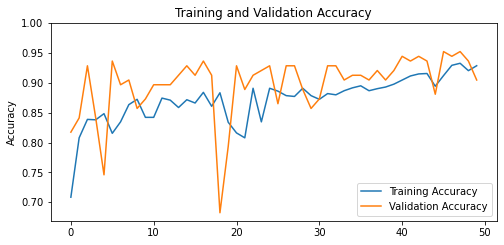

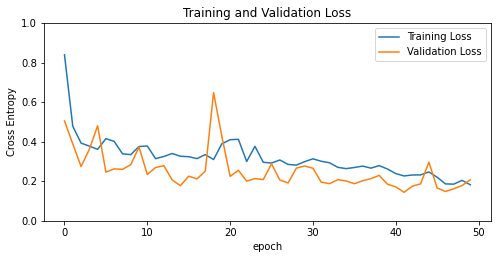

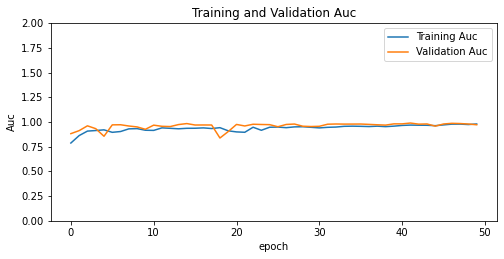

In [18]:
print_history(history2)

### 7. Evaluate the model 2

In [19]:
print_model_evaluation(model2);

714/714 [==============================] - 3s 4ms/step - loss: 0.2949 - tp: 650.0000 - fp: 64.0000 - tn: 650.0000 - fn: 64.0000 - accuracy: 0.9104 - precision: 0.9104 - auc: 0.9596 - mae: 0.1102 - mse: 0.0753
loss : 0.295
tp : 650.0
fp : 64.0
tn : 650.0
fn : 64.0
accuracy : 0.91
precision : 0.91
auc : 0.96
mae : 0.11
mse : 0.075


### 8. Predict with model 2

Label Predictions:
 [1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Real Labels:
 [1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]

Confusion Matrix:
[[13  2]
 [ 0 17]]

Accuracy: 0.94



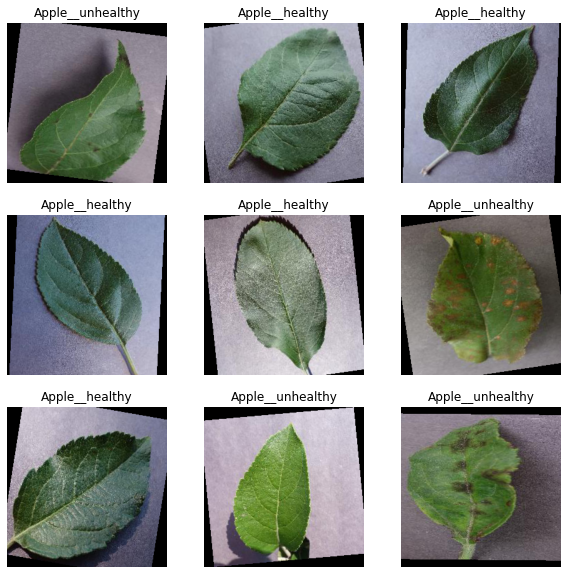

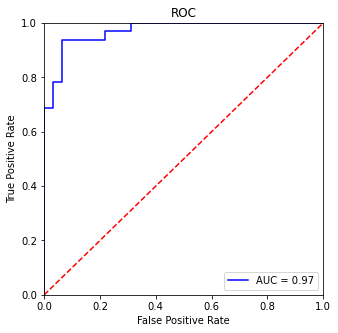

In [20]:
predict_and_print_roc(model2);


### 3. Create and compile model 3
This model has like the previous model three convolution layers. It starts with a small number of neurons and gradually increases its neuron amount. In between every convolution layer, a max pooling layer manipulates the values. Additionally, 20% of random values are dropped at the end of the hidden layers. The result from the hidden layers is then flattened with three dense layers that again gradually become smaller.

In [21]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3),
                       padding='same', activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu', use_bias=False),
    tf.keras.layers.Dense(8, activation='relu', use_bias=False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [22]:
opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model3.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=METRICS)

### 4. Display model structure 3

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      864       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 64)      18432     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 128)       73728     
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 524288)           

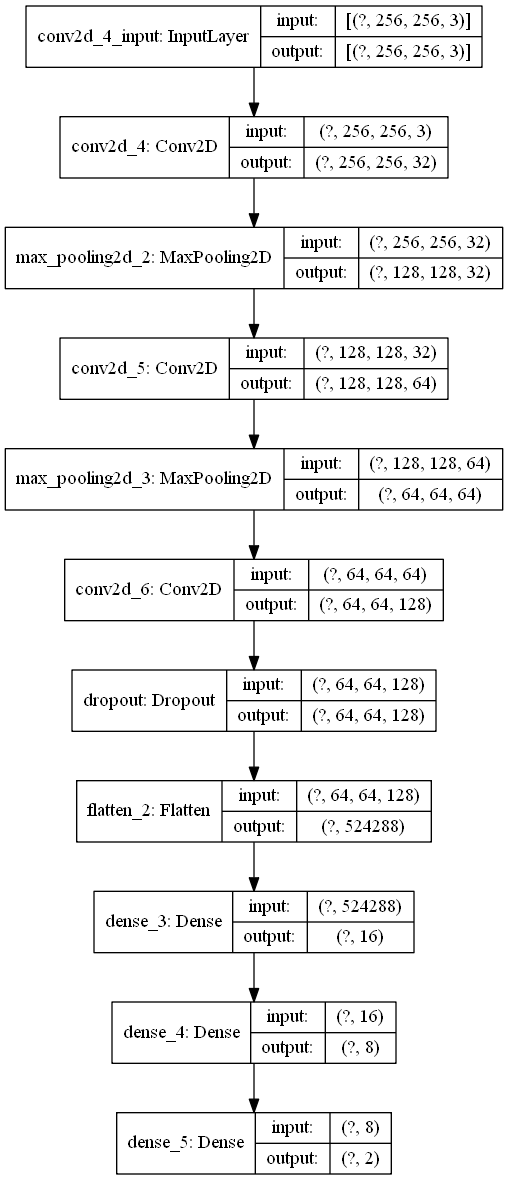

In [23]:
model3.summary()
tf.keras.utils.plot_model(model3, show_shapes=True)

### 5. Training model 3

In [24]:
history3 = train_model(model3, "Model_3")

Epoch 1/50
46/46 [==============================] - 16s 356ms/step - loss: 0.7928 - tp: 1475.0000 - fp: 697.0000 - tn: 1475.0000 - fn: 697.0000 - accuracy: 0.6791 - precision: 0.6791 - auc: 0.7693 - mae: 0.3551 - mse: 0.1954 - val_loss: 0.5186 - val_tp: 106.0000 - val_fp: 20.0000 - val_tn: 106.0000 - val_fn: 20.0000 - val_accuracy: 0.8413 - val_precision: 0.8413 - val_auc: 0.8693 - val_mae: 0.3842 - val_mse: 0.1738
Epoch 2/50
46/46 [==============================] - 15s 336ms/step - loss: 0.5012 - tp: 1149.0000 - fp: 309.0000 - tn: 1149.0000 - fn: 309.0000 - accuracy: 0.7881 - precision: 0.7881 - auc: 0.8445 - mae: 0.3200 - mse: 0.1626 - val_loss: 0.2349 - val_tp: 116.0000 - val_fp: 10.0000 - val_tn: 116.0000 - val_fn: 10.0000 - val_accuracy: 0.9206 - val_precision: 0.9206 - val_auc: 0.9697 - val_mae: 0.1596 - val_mse: 0.0633
Epoch 3/50
46/46 [==============================] - 15s 336ms/step - loss: 0.3193 - tp: 1268.0000 - fp: 190.0000 - tn: 1268.0000 - fn: 190.0000 - accuracy: 0.8697

Epoch 21/50
46/46 [==============================] - 15s 336ms/step - loss: 0.1126 - tp: 1397.0000 - fp: 61.0000 - tn: 1397.0000 - fn: 61.0000 - accuracy: 0.9582 - precision: 0.9582 - auc: 0.9918 - mae: 0.0689 - mse: 0.0323 - val_loss: 0.1342 - val_tp: 120.0000 - val_fp: 6.0000 - val_tn: 120.0000 - val_fn: 6.0000 - val_accuracy: 0.9524 - val_precision: 0.9524 - val_auc: 0.9880 - val_mae: 0.0655 - val_mse: 0.0356
Epoch 22/50
46/46 [==============================] - 15s 336ms/step - loss: 0.1593 - tp: 1366.0000 - fp: 92.0000 - tn: 1366.0000 - fn: 92.0000 - accuracy: 0.9369 - precision: 0.9369 - auc: 0.9838 - mae: 0.0911 - mse: 0.0466 - val_loss: 0.1058 - val_tp: 120.0000 - val_fp: 6.0000 - val_tn: 120.0000 - val_fn: 6.0000 - val_accuracy: 0.9524 - val_precision: 0.9524 - val_auc: 0.9936 - val_mae: 0.0614 - val_mse: 0.0316
Epoch 23/50
46/46 [==============================] - 15s 337ms/step - loss: 0.1158 - tp: 1387.0000 - fp: 71.0000 - tn: 1387.0000 - fn: 71.0000 - accuracy: 0.9513 - prec

Epoch 41/50
46/46 [==============================] - 16s 338ms/step - loss: 0.1026 - tp: 1402.0000 - fp: 56.0000 - tn: 1402.0000 - fn: 56.0000 - accuracy: 0.9616 - precision: 0.9616 - auc: 0.9933 - mae: 0.0562 - mse: 0.0301 - val_loss: 0.0863 - val_tp: 122.0000 - val_fp: 4.0000 - val_tn: 122.0000 - val_fn: 4.0000 - val_accuracy: 0.9683 - val_precision: 0.9683 - val_auc: 0.9955 - val_mae: 0.0472 - val_mse: 0.0252
Epoch 42/50
46/46 [==============================] - 15s 337ms/step - loss: 0.0572 - tp: 1427.0000 - fp: 31.0000 - tn: 1427.0000 - fn: 31.0000 - accuracy: 0.9787 - precision: 0.9787 - auc: 0.9980 - mae: 0.0352 - mse: 0.0170 - val_loss: 0.1763 - val_tp: 121.0000 - val_fp: 5.0000 - val_tn: 121.0000 - val_fn: 5.0000 - val_accuracy: 0.9603 - val_precision: 0.9603 - val_auc: 0.9866 - val_mae: 0.0540 - val_mse: 0.0330
Epoch 43/50
46/46 [==============================] - 15s 336ms/step - loss: 0.0924 - tp: 1410.0000 - fp: 48.0000 - tn: 1410.0000 - fn: 48.0000 - accuracy: 0.9671 - prec

### 6. Display History 3

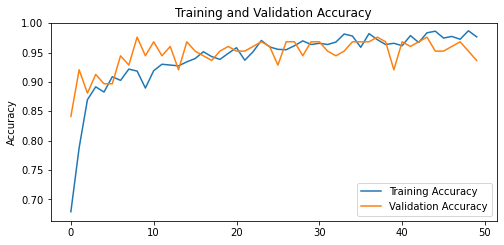

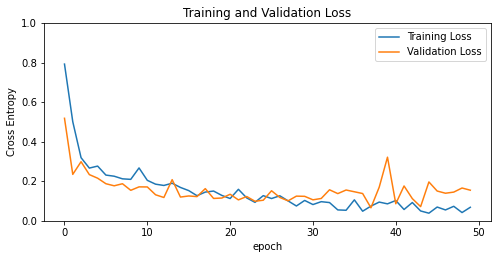

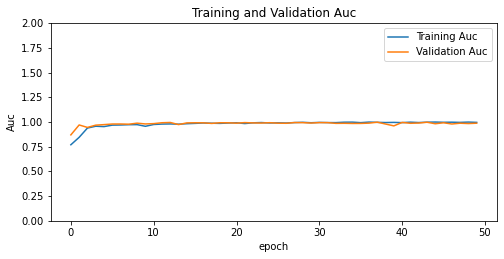

In [25]:
print_history(history3)

### 7. Evaluate the model 3

In [26]:
print_model_evaluation(model3);

714/714 [==============================] - 3s 4ms/step - loss: 0.1899 - tp: 669.0000 - fp: 45.0000 - tn: 669.0000 - fn: 45.0000 - accuracy: 0.9370 - precision: 0.9370 - auc: 0.9823 - mae: 0.0709 - mse: 0.0514
loss : 0.19
tp : 669.0
fp : 45.0
tn : 669.0
fn : 45.0
accuracy : 0.937
precision : 0.937
auc : 0.982
mae : 0.071
mse : 0.051


### 8. Predict with model 3

Label Predictions:
 [1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Real Labels:
 [1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]

Confusion Matrix:
[[14  2]
 [ 0 16]]

Accuracy: 0.94



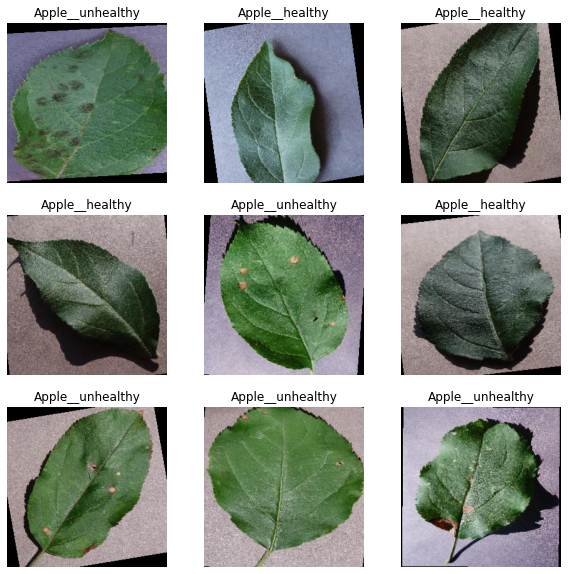

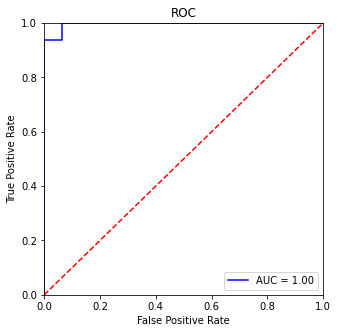

In [27]:
predict_and_print_roc(model3);

### 9. Save test model

In [28]:
model3.save(MODEL_NAME)

### 10. Load test model

In [29]:
loaded_model = tf.keras.models.load_model(MODEL_NAME)

### 11. Test loaded model on image:

Expected result: [1, 0] 

Result:  [[1. 0.]] 



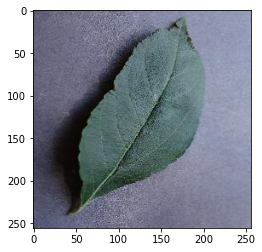

In [30]:
healthyTestImagePath = "./plant_images/test/Apple__healthy/2d7f4c07-f4f4-4589-aa82-49e05e5b253b___RS_HL 8056.jpg"

healthyTestImage = image.load_img(healthyTestImagePath)
plt.imshow(healthyTestImage)
healthyTestImage = (np.expand_dims(healthyTestImage,0))
predictions = loaded_model.predict(healthyTestImage)

print('Expected result: [1, 0] \n')
print('Result: ', predictions, '\n')

Expected result: [0, 1] 

Result:  [[0. 1.]] 



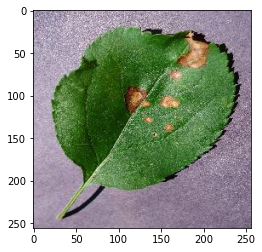

In [34]:
unhealthyTestImagePath = "./plant_images/test/Apple__unhealthy/0ebea6f4-08e4-4380-86f8-34d854697e32___JR_FrgE.S 2877.jpg"
unhealthyTestImage = image.load_img(unhealthyTestImagePath)
plt.imshow(unhealthyTestImage)
unhealthyTestImage = (np.expand_dims(unhealthyTestImage,0))
predictions = loaded_model.predict(unhealthyTestImage)

print('Expected result: [0, 1] \n')
print('Result: ', predictions, '\n')




## Summary
All the models were trained with 50 epochs. The reason for this is that after this amount no special improvments could be observed anymore and overfitting started to become a problem (tested with 100 epochs before). 

### Model 1: 
This is a very simple model that already works very well. Showing that a small amount of layers can already create a very good model.

### Model 2: 
Has more hidden and dense layers than model 1. Increasing the amount of neurons each layer, however, didn't seem to work as well as expected. Nonetheless, more layers created a better accuracy overall.

### Model 3: 
This model seems to perform the best, based on the false positive and false negative validation. Decreasing the size of the image and the neurons and leaving the amount of layers around 2-3 seemed to have the best effect.
